In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_h.shape

(60, 1)

In [5]:
sales_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_h['Sales'].sum()

4057933

Text(0.5, 1.0, 'Product H')

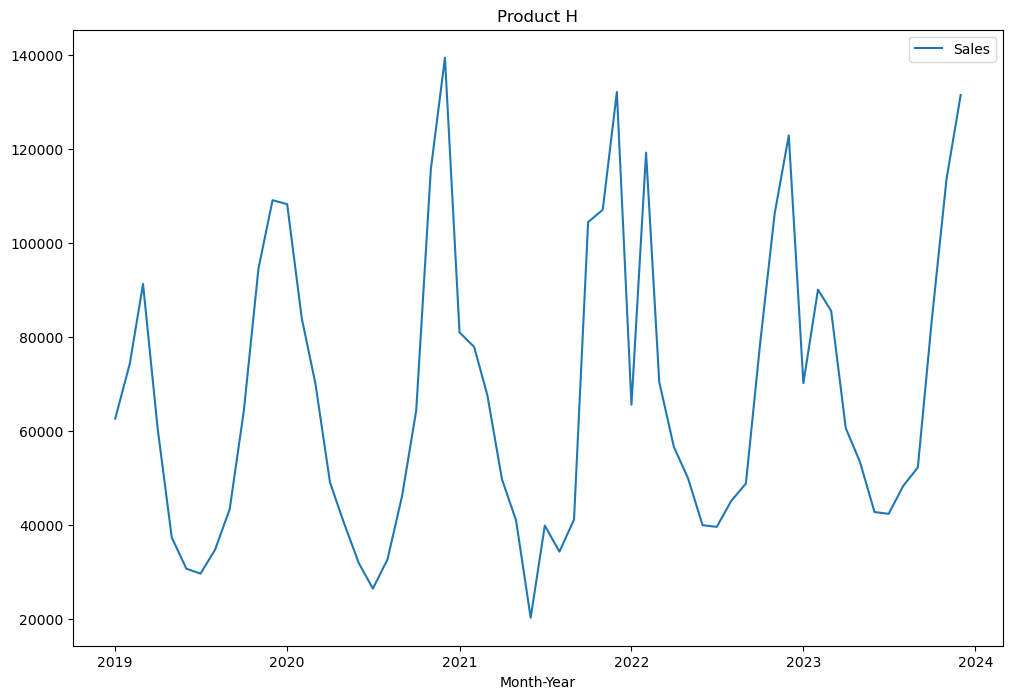

In [7]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h)
plt.title('Product H')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_h)

ADF Statistics: -1.0256008967536312
p- value: 0.7438128320877682
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_h_diff= sales_h.diff().dropna()

Text(0.5, 1.0, 'Product H- First Difference')

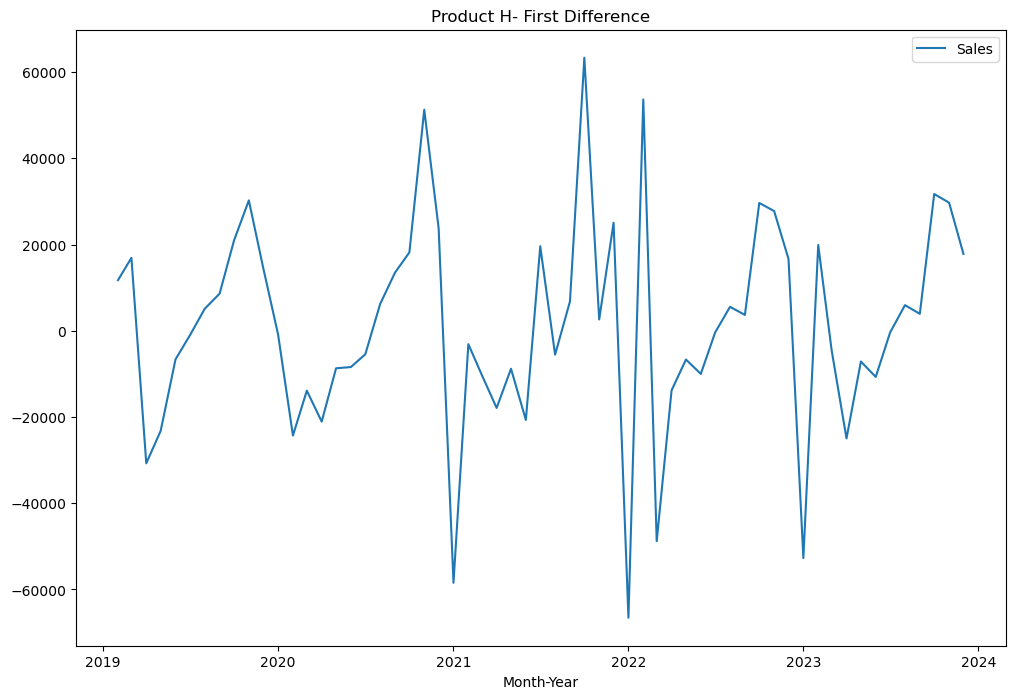

In [11]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h_diff)
plt.title('Product H- First Difference')

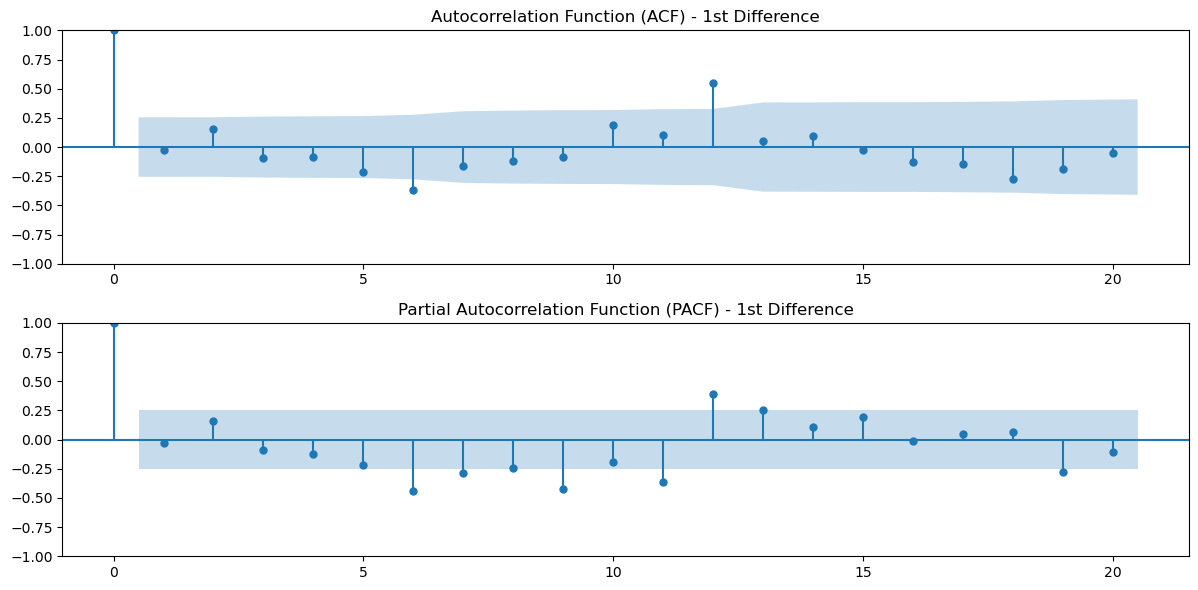

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_h_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_h_diff)

ADF Statistics: -8.916466740826941
p- value: 1.0693903940841229e-14
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_h[:48]
test=sales_h[48:]

In [15]:
len(train)

48

In [16]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(1,1,0),(1,1,1),(1,1,2),(2,1,0), (2,1,1), (2, 1, 2),(3,1,0),(3,1,1),(3,1,2),(4,1,0),(4,1,1),(4,1,2),(5,1,0),(5,1,1),(5,1,2)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_h, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_h)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1080.114842  1093.065875  12658.747227  3.092486e+08  17585.466394
11  3  2  1080.685727  1091.786612  12500.374452  3.156886e+08  17767.627706
17  5  2  1081.264137  1096.065318  11408.046428  2.775722e+08  16660.499023
10  3  1  1083.655021  1092.905759  19293.426359  6.509387e+08  25513.500373
13  4  1  1084.466234  1095.567120  17406.628910  5.427913e+08  23297.881469
16  5  1  1084.834910  1097.785943  15222.095343  4.290981e+08  20714.683074
0   0  0  1088.662539  1090.512687  51458.333333  3.259839e+09  57095.002534
2   0  2  1090.296738  1095.847181  58333.333146  4.156765e+09  64472.978166
6   2  0  1090.371306  1095.921749  60900.083193  4.473294e+09  66882.686494
3   1  0  1090.656554  1094.356850  51384.448394  3.250977e+09  57017.342530
1   0  1  1090.664692  1094.364987  51405.198095  3.253464e+09  57039.145622
9   3  0  1090.972899  1098.373489  49654.834549  3.029025e+09  55036.577754

In [20]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -533.057
Date:                Thu, 09 May 2024   AIC                           1080.115
Time:                        18:11:40   BIC                           1093.066
Sample:                    01-01-2019   HQIC                          1084.988
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3151      0.358      3.675      0.000       0.614       2.016
ar.L2         -0.3154      0.434     -0.727      0.467      -1.166       0.535
ar.L3         -0.3698      0.360     -1.026      0.3

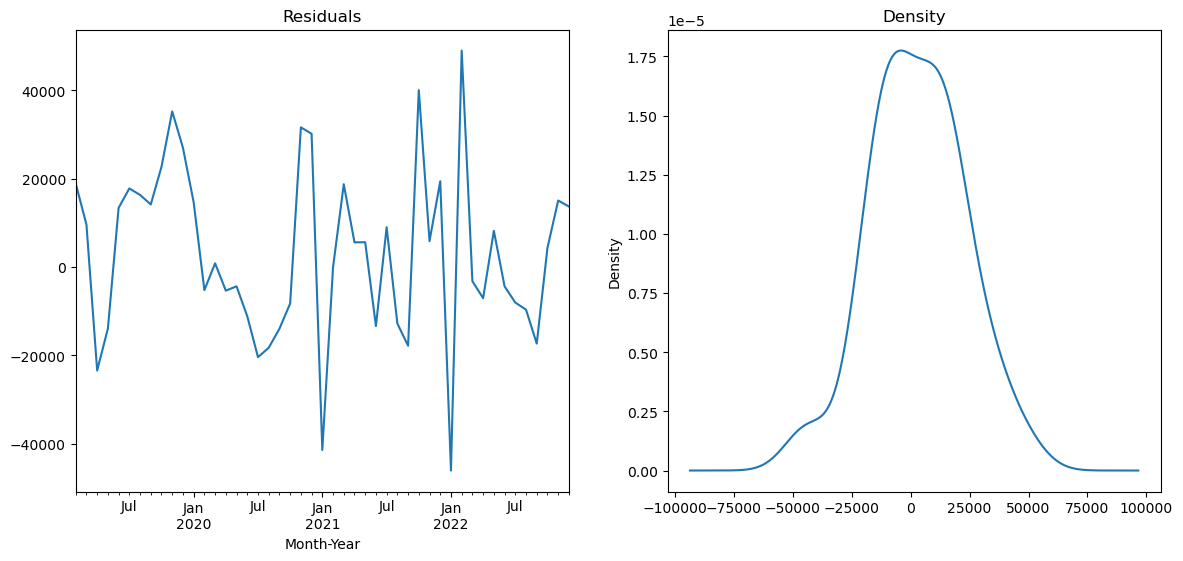

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

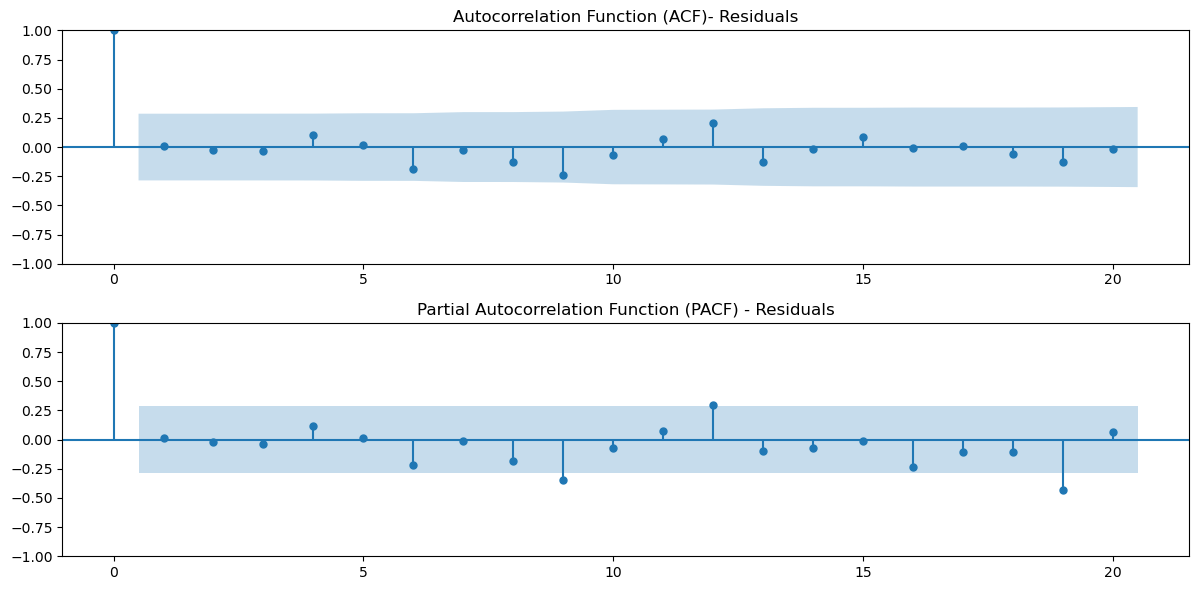

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

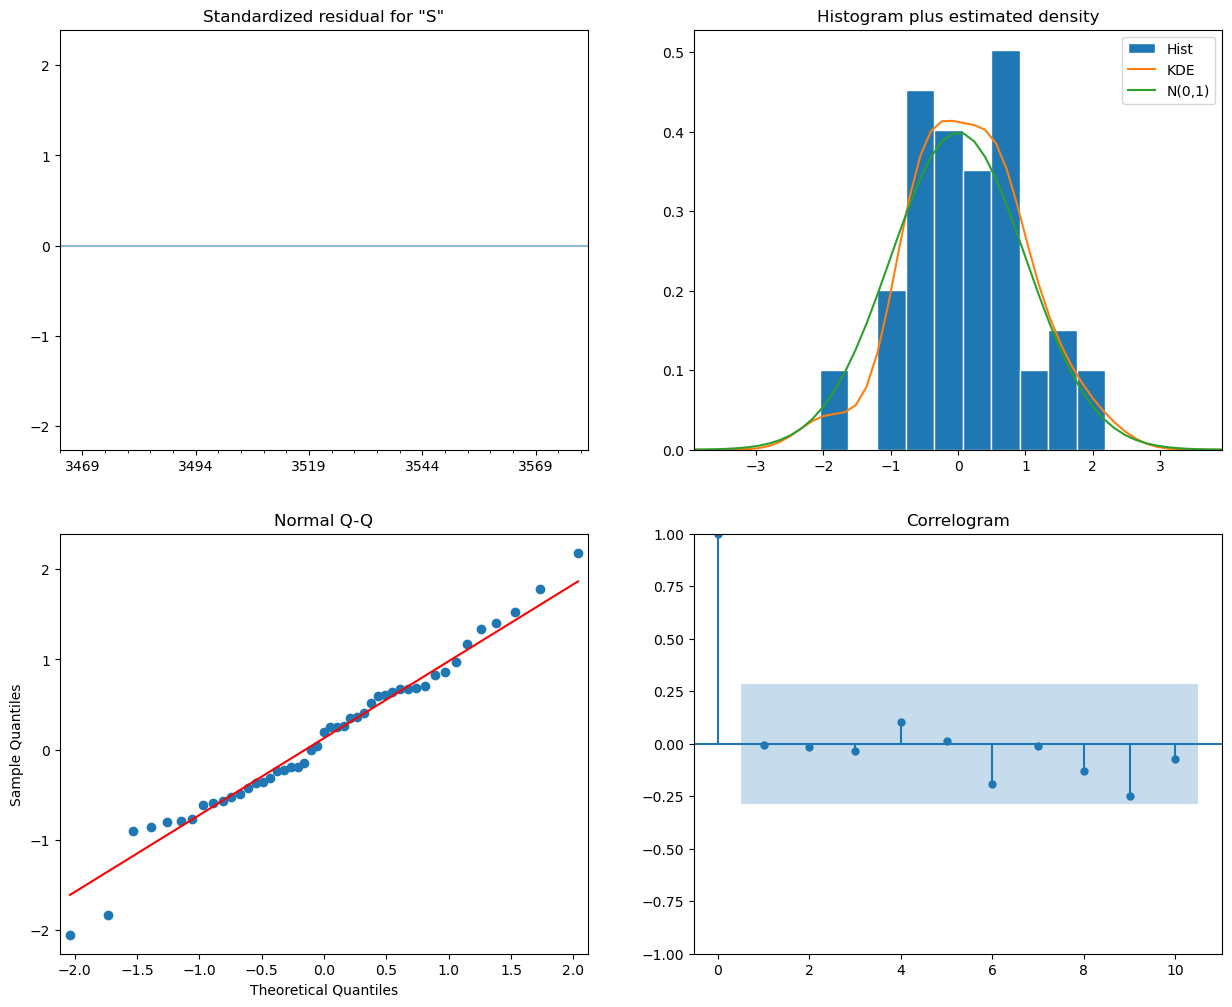

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_h['Forecast_ARIMA']=[None]*len(train) + list(pred)
#plt.figure(figsize=(14, 6))
#sales_h.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_h)-1), dynamic = True)
sales_h['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product H')

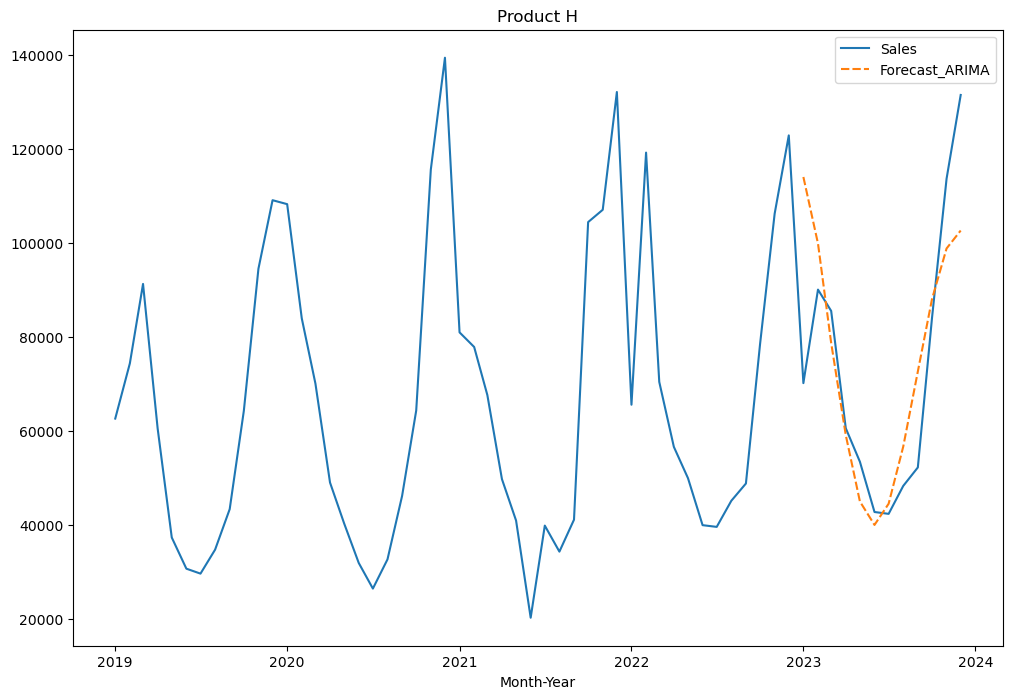

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h)
plt.title('Product H')

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 12658.747227408894
MAPE - ARIMA: 0.17272169151686081
MSE - ARIMA: 309248628.28022814
RMSE - ARIMA: 17585.466393594117


# SARIMA

In [28]:
import statsmodels.api as sm

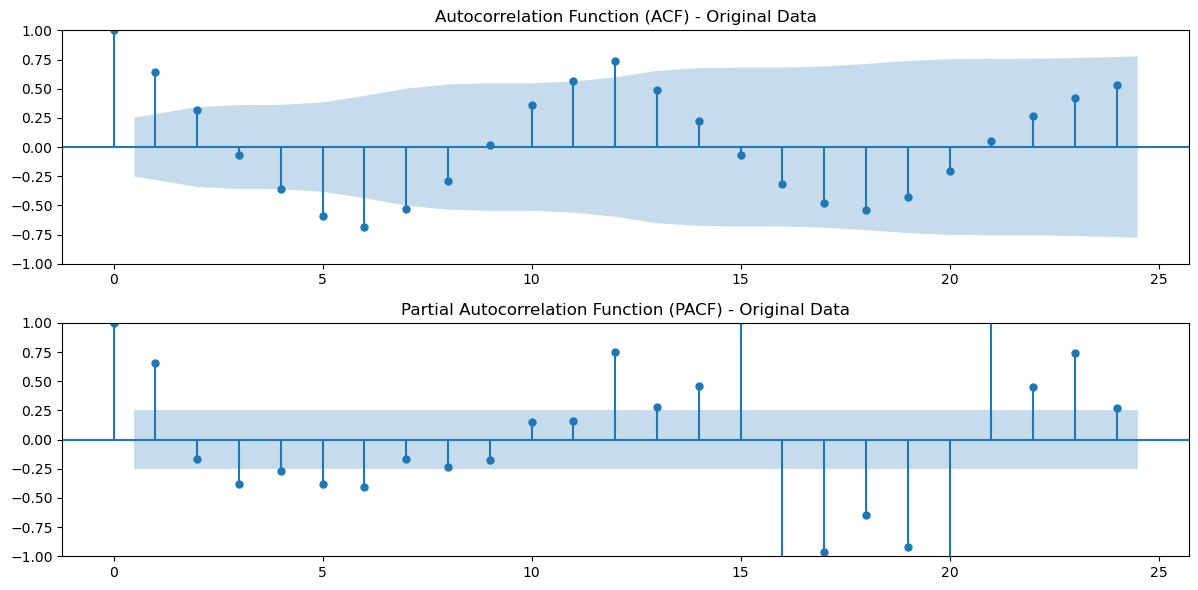

In [29]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_h['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

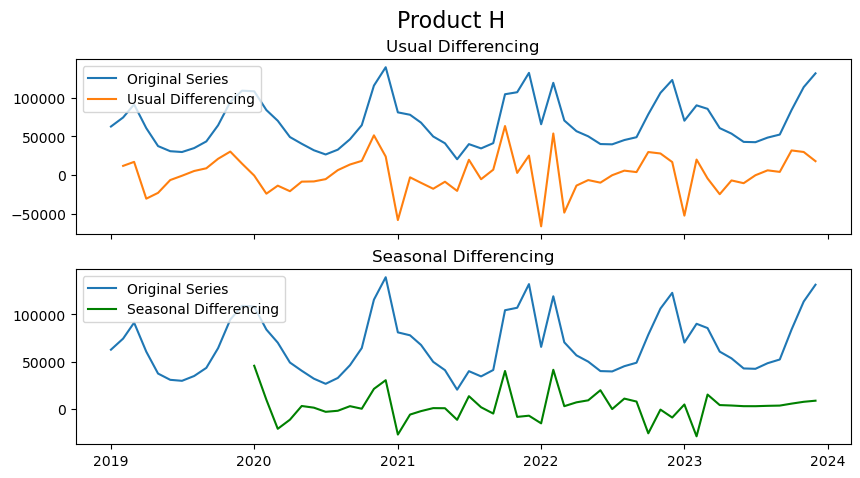

In [30]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_h['Sales'], label='Original Series')
axes[0].plot(sales_h['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_h['Sales'], label='Original Series')
axes[1].plot(sales_h['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product H', fontsize=16)
plt.show()

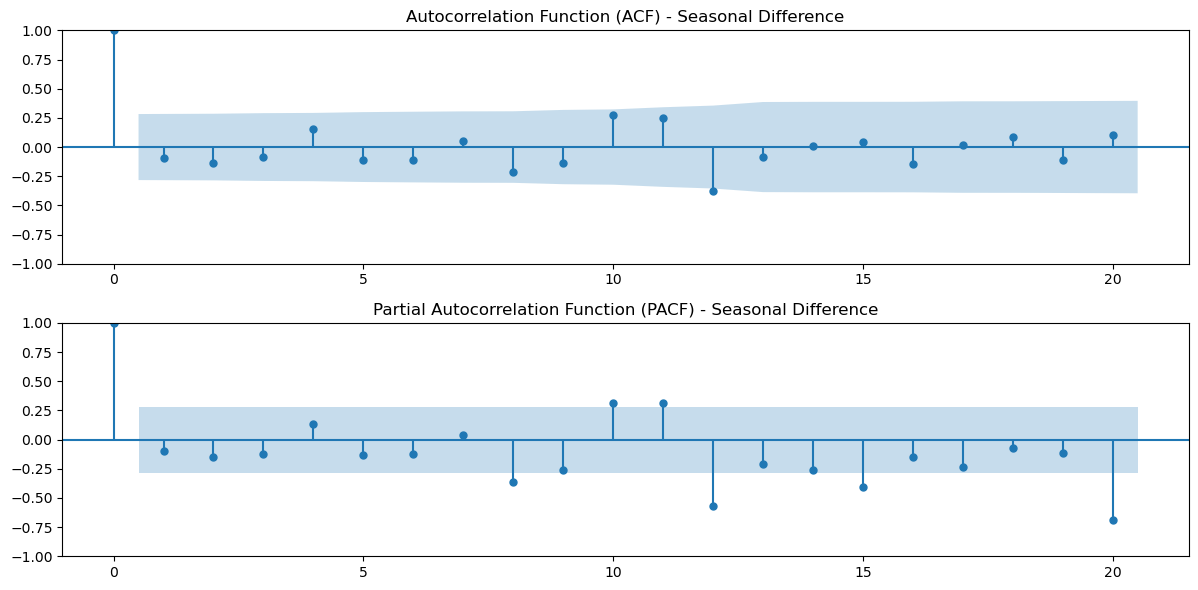

In [31]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_h['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_h['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

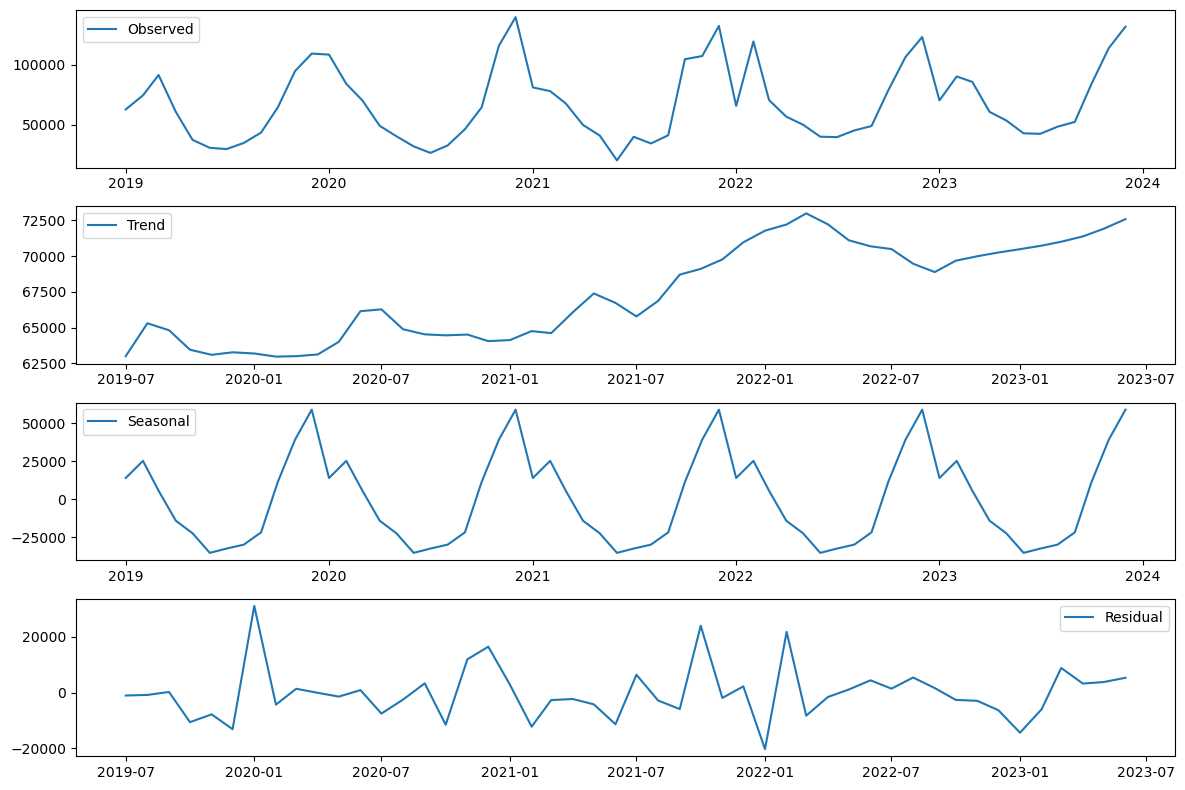

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_h['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [34]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic           mae           mse
5   2  1  814.034141  829.587622  17585.469234  4.048251e+08
3   1  1  814.456610  828.454742   8510.426789  1.094077e+08
6   3  0  814.628216  830.181696  32288.046081  1.126292e+09
4   2  0  815.322602  829.320734   5722.782459  9.835453e+07
8   4  0  815.867298  832.976127  20550.923447  5.322982e+08
7   3  1  815.942232  833.051061  21836.952755  5.797086e+08
0   0  0  816.310347  827.197784   7112.258384  9.633438e+07
1   0  1  817.302849  829.745634   6491.924420  6.836308e+07
2   1  0  817.787850  830.230634   7317.092492  8.440356e+07
10  5  0  817.867299  836.531476  20550.713629  5.323046e+08
9   4  1  817.867303  836.531479  20550.059512  5.323333e+08
11  5  1  819.867299  840.086823  20549.138238  5.321937e+08


In [35]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 2),seasonal_order=(2,1,1,12))
sarima_model=sarima.fit()

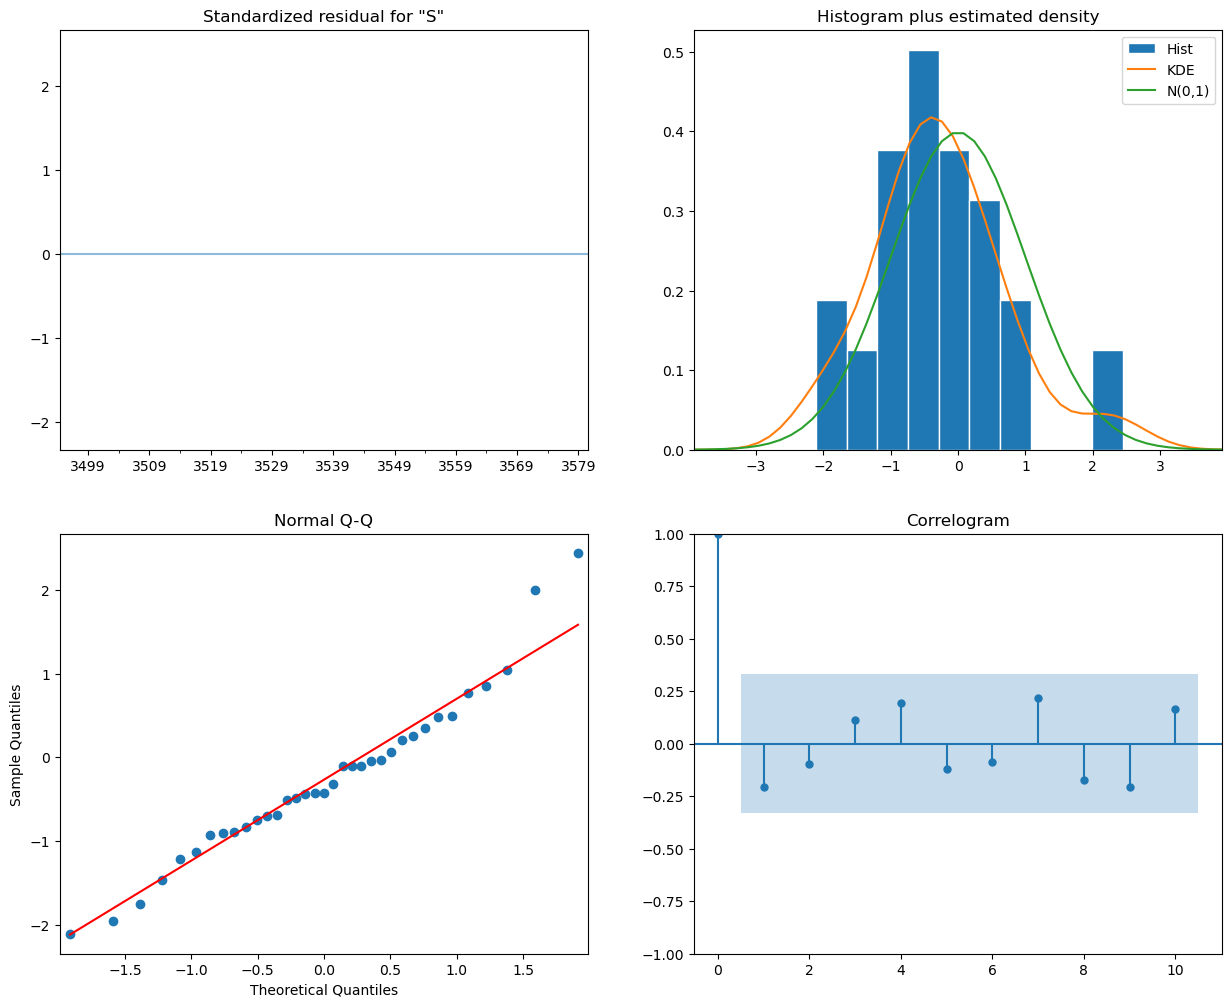

In [36]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
forecast_test_sarima=sarima_model.predict(start=48,end=59,dynamic=True)

In [38]:
sales_h['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product H')

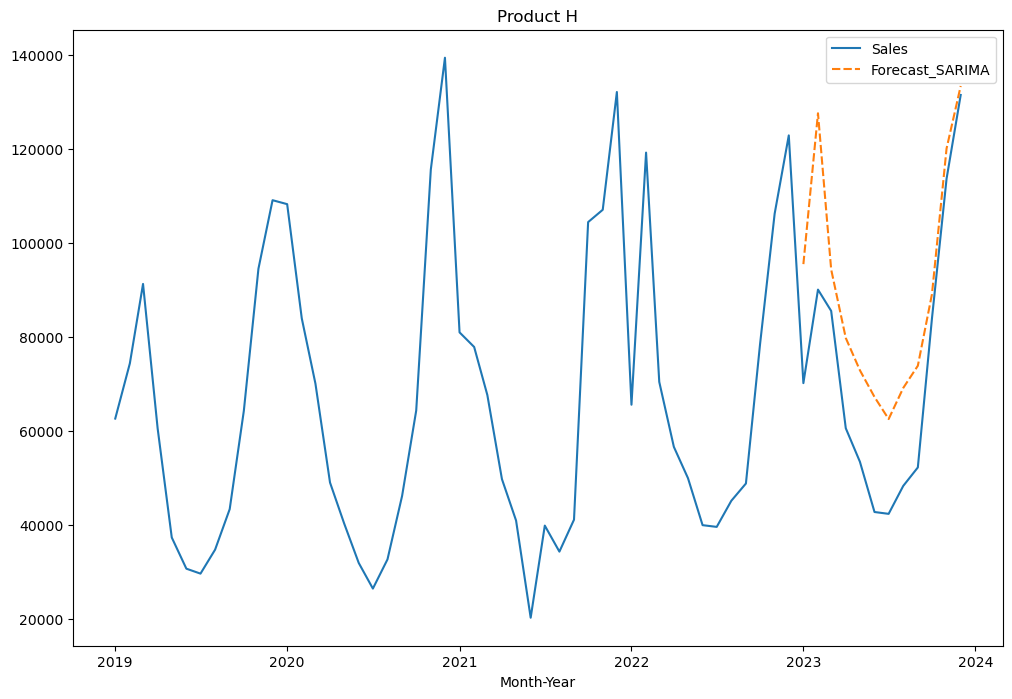

In [39]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_SARIMA']])
plt.title('Product H')

In [40]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 17585.469
MAPE - SARIMA: 0.299
MSE - SARIMA: 404825128.816
RMSE - SARIMA: 20120.267


# AUTO-ARIMA

In [41]:
import pmdarima as pm

In [42]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=806.435, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=808.104, Time=0.12 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=808.232, Time=0.37 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=808.308, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=809.843, Time=0.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=808.650, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=809.739, Time=0.76 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=811.447, Time=1.56 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=809.569, Time=1.52 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=811.431, Time=2.85 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=813.315, Time=2.65 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=811.569, Time=1.95 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=813.431, Time=2.79 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=813.569, Time=4.40 sec
 ARIMA(0,1,1)(

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -399.420
Date:                             Thu, 09 May 2024   AIC                            804.840
Time:                                     18:19:48   BIC                            809.506
Sample:                                 01-01-2019   HQIC                           806.451
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5381      0.156      3.457      0.001       0.233       0.843
ma.L1         -0.8749      0.135     -6.480      0.000      -1.140      -0.610
sigma2      4.779e+08   3.59e-11   1.33e+19      0.000    4.78e+08    4.78e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.96   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.16   Prob(JB):                         0.56
Heteroskedasticity (H):               0.67   Skew:                             0.16
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.02e+35. Standard errors may be unstable.
"""

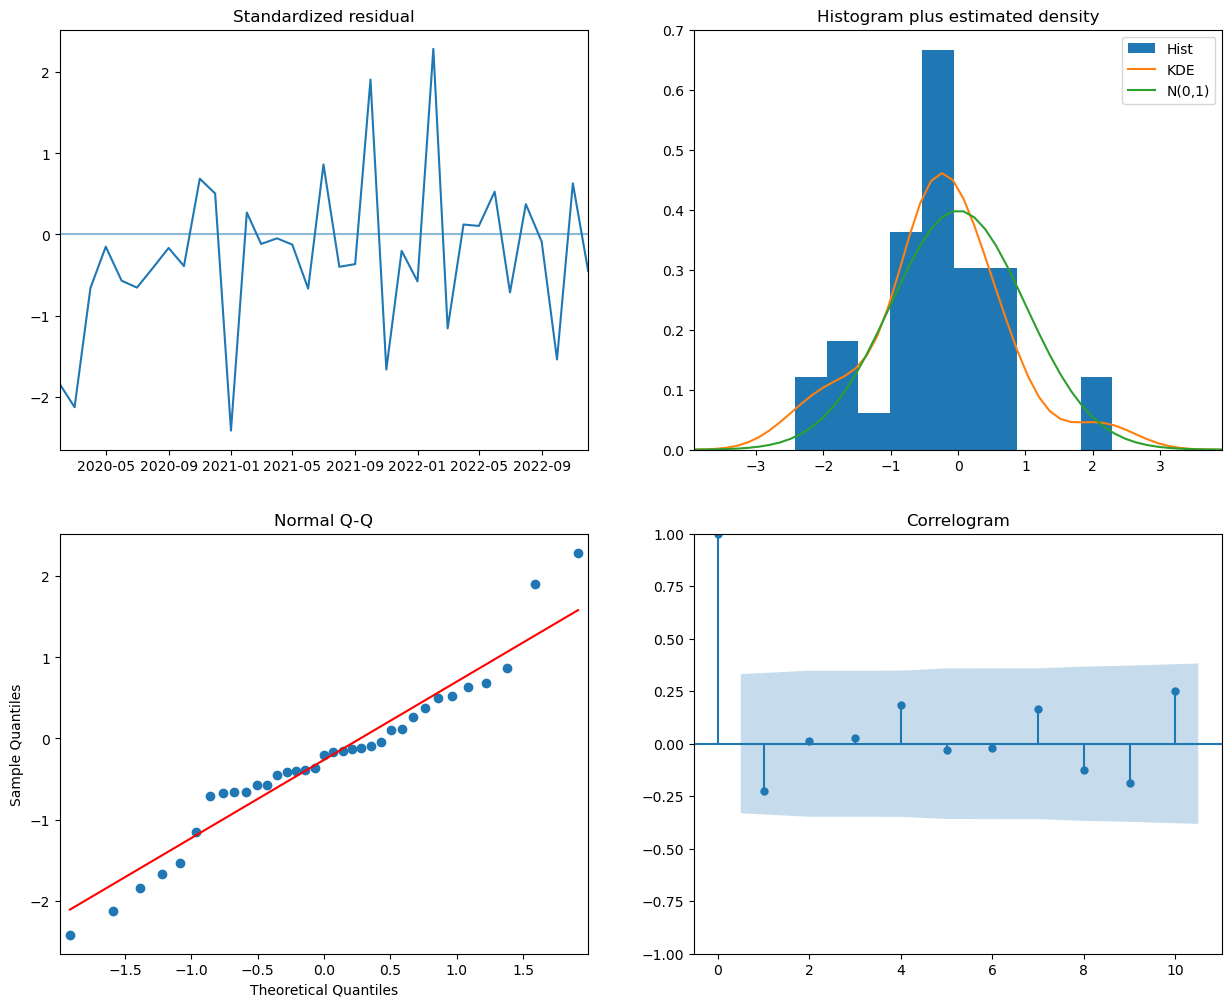

In [44]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_h['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_h.plot()

Text(0.5, 1.0, 'Product H')

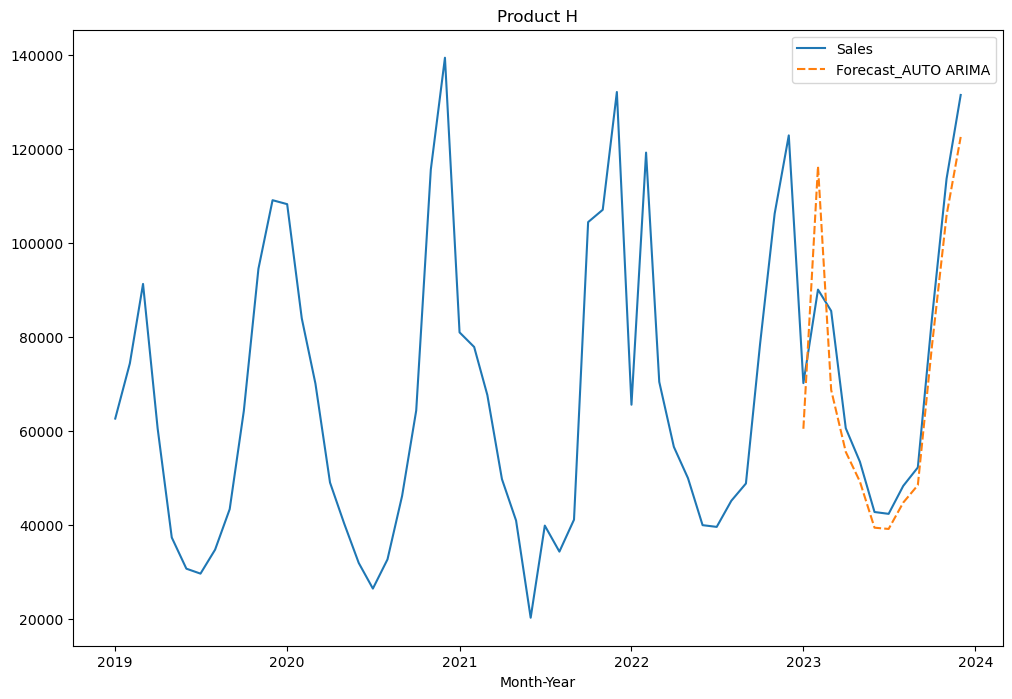

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product H')

In [47]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 8206.388408195056
MAPE - AUTO ARIMA: 0.10777257349710491
MSE - AUTO ARIMA: 111059281.00671504
RMSE - AUTO ARIMA: 10538.466729402102


In [48]:
sales_h.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,70232,114112.064258,95564.920766,60517.647890
2023-02-01,90139,99948.334925,127673.968631,116399.859488
2023-03-01,85600,78776.841168,94422.895839,68782.385283
2023-04-01,60633,59170.139519,79842.837245,55597.073908
2023-05-01,53500,45038.992514,72968.553113,49275.361441
2023-06-01,42800,40048.526919,67283.134223,39461.157911
2023-07-01,42408,44564.965878,62587.277514,39194.133510
2023-08-01,48352,56722.038758,69202.217847,44803.929583
2023-09-01,52288,72710.768204,73929.691813,48511.876821


In [49]:
sales_h.mean()

Sales                  67632.216667
Forecast_ARIMA         75065.633179
Forecast_SARIMA        90525.802567
Forecast_AUTO ARIMA    69110.754840
dtype: float64

In [50]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,12658.747227,0.172722,3.092486e+08,17585.466394
AUTO ARIMA,8206.388408,0.107773,1.110593e+08,10538.466729
SEASONAL ARIMA,17585.469234,0.298863,4.048251e+08,20120.266619


# TESTING

In [16]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=6,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=806.434, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=808.338, Time=0.06 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=808.964, Time=0.23 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=808.360, Time=0.09 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=809.742, Time=0.20 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=809.683, Time=0.64 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=809.021, Time=0.29 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=809.703, Time=0.76 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=811.681, Time=1.26 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=806.523, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=808.506, Time=0.22 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=809.322, Time=0.45 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=808.510, Time=0.19 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,0,1)(2,1,

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [17]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.026
Date:                            Wed, 08 May 2024   AIC                            806.052
Time:                                    19:52:47   BIC                            810.803
Sample:                                01-01-2019   HQIC                           807.710
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2079.4174   2564.142      0.811      0.417   -2946.209    7105.043
ar.L1          0.1827      0.081      2.247      0.025       0.023       0.342
sigma2       2.34e+08      0.061   3.82e+09      0.000    2.34e+08    2.34e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):                 2.61
Prob(Q):                              0.15   Prob(JB):                         0.27
Heteroskedasticity (H):               1.52   Skew:                             0.53
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.41e+25. Standard errors may be unstable.
"""

In [18]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_h['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product H')

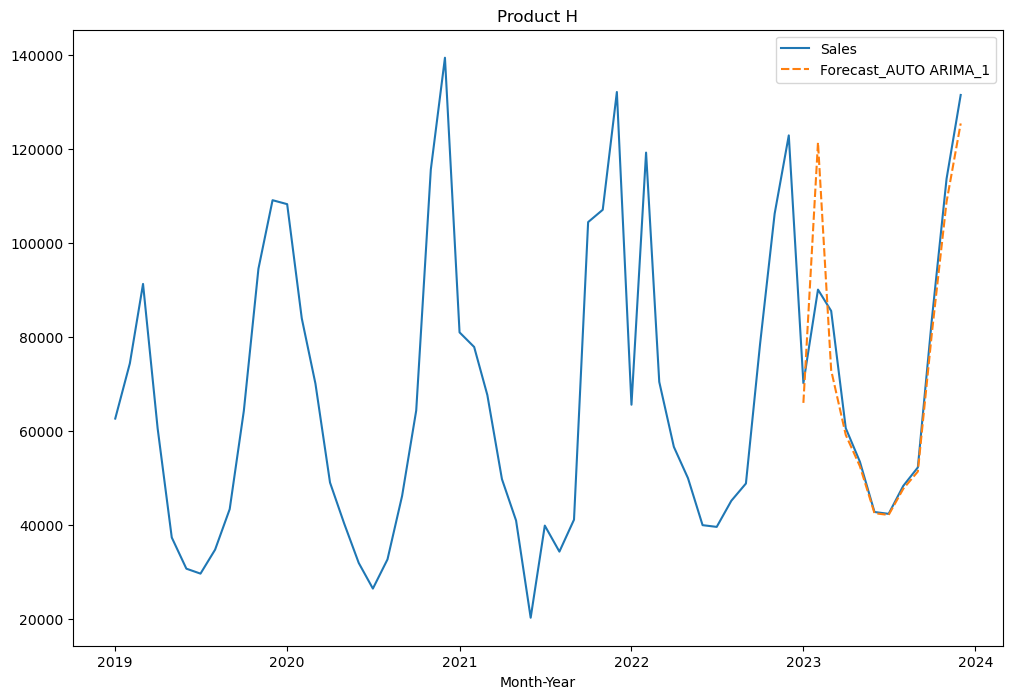

In [19]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_h[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product H')

In [20]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 5536.709649943378
MAPE - AUTO ARIMA: 0.0634739111528149
MSE - AUTO ARIMA: 102639467.5694958
RMSE - AUTO ARIMA: 10131.113836567813
